In [0]:
# coding: utf-8
import random
import csv
import os
import time
from pathlib import Path
from tqdm import tqdm
from easydict import EasyDict
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image,ImageOps
from PIL import ImageEnhance
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
%matplotlib inline

In [0]:
from pytorch_MultiResUNet import MultiResUNet

In [0]:
settings = EasyDict({
    'size': {
        'width': 128,
        'height': 128
    },
    'input_channel': 3,
    'nclass': 1,
    'batchsize': 38,
    'epochs': 10,
})

In [0]:
use_gpu = torch.cuda.is_available()

model = MultiResUNet(
    n_channels=settings.input_channel,
    n_classes=settings.nclass,
    patch_width=settings.size.width,
    patch_height=settings.size.height)
opt_net = torch.optim.RMSprop(model.parameters(), lr=0.002)
BCE_loss = torch.nn.BCELoss()

if (use_gpu):
    model.cuda()
    BCE_loss.cuda()

In [4]:
model

MultiResUNet(
  (mresblock1): MultiResBlock(
    (conv3x3): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3x3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5x5): Conv2d(8, 17, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn5x5): BatchNorm2d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv7x7): Conv2d(17, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn7x7): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Conv2d(3, 51, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn_shortcut): BatchNorm2d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn_concat): BatchNorm2d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn_out): BatchNorm2d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (respath1): ResPath1(
    (s

In [0]:
def img_loader_from_path(path, width=256, height=256, nclass=1, batchsize=1, normalize=True, augment=False, shuffle=False):
   
    images = []
    labels = []
    
    while 1:
        
        if shuffle:
            random.shuffle(path)
        
        for (x,t) in path:
            img_input = cv2.cvtColor(cv2.resize(cv2.imread(x),(width, height)), cv2.COLOR_BGR2RGB)
            img_input = img_input.reshape(width, height, 3).astype(np.float32)
            
            label = cv2.resize(cv2.imread(t), (width, height))[:,:,2]
            label = label.reshape(width, height, nclass)
            
            data = np.c_[img_input, label]
            
            if augment:
                isflip = random.random()
                if (isflip < 0.5):
                    data = data[:, ::-1, :]

            if normalize:
                data = data / 255.
            
            images.append(data[:,:,:3])
            labels.append(data[:,:,3:].reshape(width*height, nclass))          
            if len(images) == batchsize and len(labels) == batchsize:
                x = np.array(images, dtype=np.float32)
                x = np.transpose(x,axes=(0,3,1,2))
                t = np.array(labels, dtype=np.float32)
                images = []
                labels = []
                yield (x,t)   

In [0]:
img_pairs = []

annotations_path = Path('./HDSeg/annotations/DogSeg/')
annotations_files = [x for x in annotations_path.iterdir() if annotations_path.is_dir()]

for af in annotations_files:
    input_images_path = Path('./images/DogSeg') / af.stem
    if(input_images_path.is_dir()):
        input_images_files = [x for x in input_images_path.iterdir()]
        af_imgs = [ x for x in af.iterdir()]
        for af_img in af_imgs:
            af_img_id = af_img.stem[:-3]
            if(af_img.suffixes[0] == '.no'):
                for input_img in input_images_files:
                    if(af_img_id == input_img.stem):
                        img_pairs.append((str(input_img), str(af_img)))
                        
annotations_path = Path('./HDSeg/annotations/DogSeg/voc12')
annotations_files = [x for x in annotations_path.iterdir() if annotations_path.is_dir()]

for af_img in annotations_files:
    input_img = Path('./images/DogSeg/voc12') / (af_img.stem[:-3] + '.JPEG')
    if(input_img.is_file()):
        img_pairs.append((str(input_img), str(af_img)))

In [7]:
train_pairs = img_pairs[500:]
test_pairs = img_pairs[:500]

print(len(train_pairs),len(test_pairs))

4446 500


In [0]:
train_loader = img_loader_from_path(
    path=train_pairs,
    width=settings.size.width,
    height=settings.size.height,
    nclass=settings.nclass,
    batchsize=settings.batchsize,
    normalize=True,
    augment=True,
    shuffle=True) 

In [10]:
steps = len(train_pairs) // settings.batchsize

for epoch in range(settings.epochs):

    total_loss = 0.0          
    start_time = time.time()
    for s in tqdm(range(steps)):

        (X_train,t_train) = next(train_loader)

        if(use_gpu):
            X_train = Variable(torch.from_numpy(X_train).cuda())
            t_train = Variable(torch.from_numpy(t_train).cuda())
        else:
            X_train = Variable(torch.from_numpy(X_train))
            t_train = Variable(torch.from_numpy(t_train).cuda())
            
        X_output = model(X_train)
        segmentation_loss = BCE_loss(X_output, t_train)
        total_loss += segmentation_loss.item()
        opt_net.zero_grad()
        segmentation_loss.backward()
        opt_net.step()
                
    # 1epoch finished
    end_time = time.time()

    total_loss = total_loss / steps

    print("[Train] epoch: %d, unet loss : %f, time : %f" % (epoch, total_loss, end_time - start_time))

  0%|          | 0/117 [00:00<?, ?it/s]

[Train] epoch: 0, unet loss : 0.481461, time : 210.299475


  0%|          | 0/117 [00:00<?, ?it/s]

[Train] epoch: 1, unet loss : 0.389728, time : 210.683770


  0%|          | 0/117 [00:00<?, ?it/s]

[Train] epoch: 2, unet loss : 0.368976, time : 210.547457


  0%|          | 0/117 [00:00<?, ?it/s]

[Train] epoch: 3, unet loss : 0.352248, time : 210.508970


  0%|          | 0/117 [00:00<?, ?it/s]

[Train] epoch: 4, unet loss : 0.341838, time : 210.594535


  0%|          | 0/117 [00:00<?, ?it/s]

[Train] epoch: 5, unet loss : 0.331183, time : 210.439654


  0%|          | 0/117 [00:00<?, ?it/s]

[Train] epoch: 6, unet loss : 0.321912, time : 210.543093


  0%|          | 0/117 [00:00<?, ?it/s]

[Train] epoch: 7, unet loss : 0.314502, time : 210.501295


  0%|          | 0/117 [00:00<?, ?it/s]

[Train] epoch: 8, unet loss : 0.306986, time : 210.438992


100%|██████████| 117/117 [03:30<00:00,  1.81s/it]

[Train] epoch: 9, unet loss : 0.297443, time : 210.594693


In [0]:
test_loader = img_loader_from_path(
    path=test_pairs,
    width=settings.size.width,
    height=settings.size.height,
    nclass=settings.nclass,
    batchsize=10,
    normalize=True,
    augment=False,
    shuffle=False) 

In [0]:
(X_test,t_test) = next(test_loader)

model.eval()
with torch.no_grad():

    if(use_gpu):
        X_test = Variable(torch.from_numpy(X_test).cuda())
    else:
        X_test = Variable(torch.from_numpy(X_test))
    unet_output = model(X_test).cpu().detach().numpy()

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


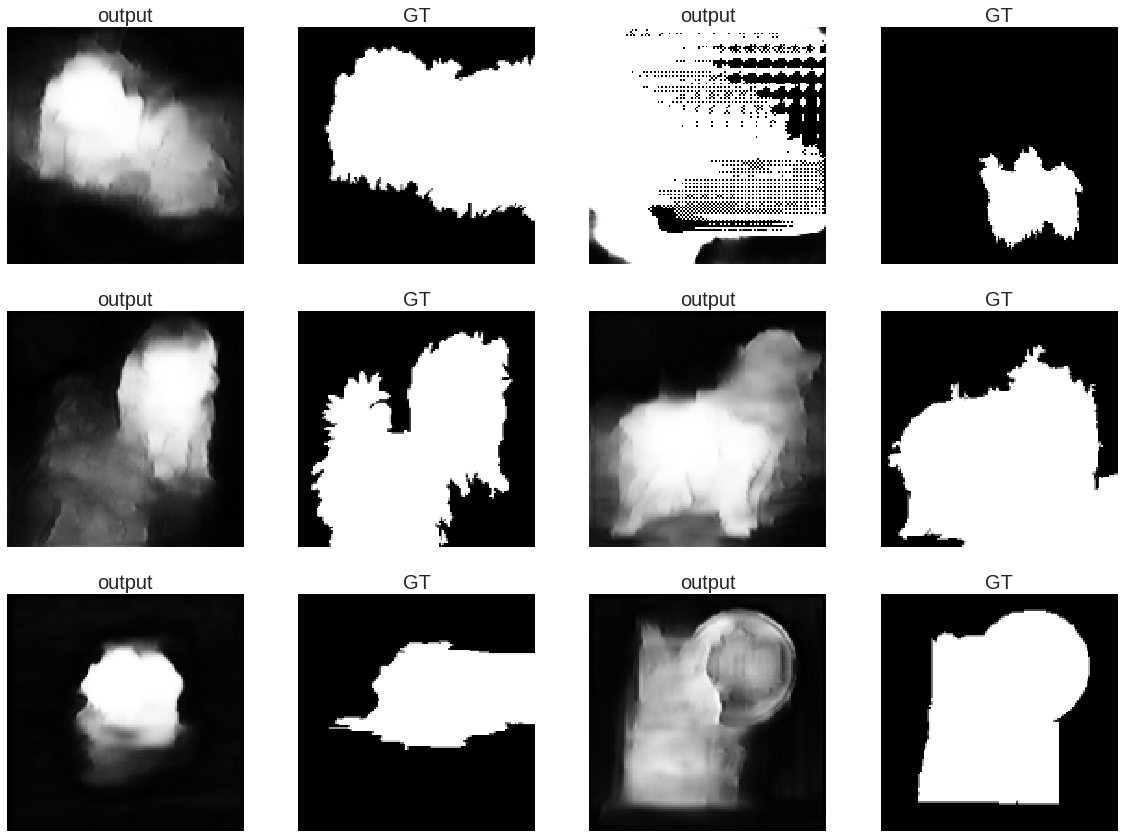

In [26]:
plt.figure(figsize=(20,20))

plt.tick_params(labelbottom='off')
plt.tick_params(labelleft='off')

for i in range(0,6):
    plt.subplot(4, 4, (i*2)+1)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.grid(False)
    plt.title('output',fontsize=20)
    plt.imshow(unet_output[i,:,0].reshape(settings.size.width,settings.size.height),'gray')

    plt.subplot(4, 4, (i*2)+2)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.grid(False)
    plt.title('GT',fontsize=20)
    plt.imshow(t_test[i,:,0].reshape(settings.size.width,settings.size.height),'gray')

plt.show()